## 9-Solving Graph Coloring Problem with PyQUBO
この節では、[Ising formulations of many NP problems](https://arxiv.org/pdf/1302.5843v3.pdf) から6.1. Graph ColoringをPyQUBOを用いて解きます。

### グラフ彩色問題
グラフ彩色問題は以下のような状況の最適解を求める問題であり、NP完全問題の一つです。まずは具体的な問から考えてみましょう。

### 具体例
分かりやすくするために具体的に以下のような問を考えます。
> 10個のノードと20本の枝を持つ無効グラフが与えられたとします。枝で繋がれたノード同士は異なる色となるようにノードを色分けする時、3色で全てのノードを塗ることは可能であるか考えます。
> グラフは下のようになっているとします。

<div>
    <img src="graph_color.png">
</div>

> 塗り分けた後のグラフは下のようになります。
> このグラフから全てのノードは3色で塗り分けることができると分かります。

<div>
    <img src="graph_color_res.png">
</div>

### 問題の一般化
無効グラフ$G=(V,E)$が与えられるとします。辺で結ばれたノードの色が重複しないように全てのノードを$n$色で塗り分けることができるか考えます。

全てのノードが$v$をindexとして持つとします。


ノードの色分けはバイナリ変数$x$で表すことにしましょう。$x_{v,i}$はノード$v$が色$i$で塗られている時に1,その他の状態では0をとります。

## QUBO行列への変換
ハミルトニアンは以下のように定めることができます。

$$H = A\sum_{v=1}^V\left(1-\sum_{i=1}^n x_{v,i}\right)^2
+ A\sum_{(uv)\in E}\sum_{i=1}^nx_{u,i}x_{v,i}$$

第一項はそれぞれのノードは必ず一色に塗られるという制約です。第二項は辺で繋がれたノードの色は異なるという制約です。これらが破られる度に$H$は増加します。

$H=0$となる状態が見つかった時、グラフ$G$は$n$色で塗ることが可能だと分かります。

また、$x_{v,i}$でどのiの時$x_{v,i}=1$となるか調べることでノード$v$の色を調べることができます。

## PyQUBOへの実装
### QUBO行列の生成
上記の例で示したグラフの彩色問題を実際にQUBO行列にしてPyQUBOを用いて解いてみます。
まず、グラフの頂点数、塗り分けるのに使う色の数、辺を定義します。

In [191]:
#頂点数
N_VER = 10
#色の数
N_COLOR = 4
#辺の数
N_EDGE = 20
#辺のリスト
graph = [(7, 5), (1, 6), (9, 0), (8, 9), (1, 2), (0, 6), (3, 4), (8, 2), (7, 1), (1, 5), (7, 0), (2, 4), (9, 3), (2, 0), (0, 1)]

次にバイナリ変数xを定義します。

In [188]:
#PYQUBOをimportします
from pyqubo import Array
#QUBOを表現する変数(頂点数×色の数)
x = Array.create('x', shape=(N_VER,N_COLOR), vartype='BINARY')

この変数を用いてハミルトニアンを定義します。

In [189]:
from pyqubo import Constraint
# ハミルトニアンの第一項 (各頂点に1色だけ塗る)
H_A = Constraint(sum((1-sum(x[v,i] for i in range(1,N_COLOR)))**2 for v in range(N_VER)), label='HA')
# ハミルトニアンの第二項 (辺で結ばれた頂点が同じ色で塗られていないか)
H_B = sum(sum(x[u,i] * x[v,i] for i in range (1,N_COLOR)) for u,v in graph)
# ハミルトニアン全体を定義します
Q = H_A+H_B

### 実行結果

ハミルトニアンをコンパイルしてto_qubo()でQUBOに変換します。
quboにはPythonの辞書型で格納されたQUBOが、そしてoffsetにはQUBO化した際に現れる定数(無視してよい)が代入されます。

では、これをSimulated Annealingのソルバーで解いて結果を見てみましょう。

[Result]

{0: {1: 1, 2: 0, 3: 0}, 1: {1: 0, 2: 1, 3: 0}, 2: {1: 0, 2: 0, 3: 1}, 3: {1: 1, 2: 0, 3: 0}, 4: {1: 0, 2: 1, 3: 0}, 5: {1: 1, 2: 0, 3: 0}, 6: {1: 0, 2: 0, 3: 1}, 7: {1: 0, 2: 0, 3: 1}, 8: {1: 0, 2: 1, 3: 0}, 9: {1: 0, 2: 0, 3: 1}}

broken
{}



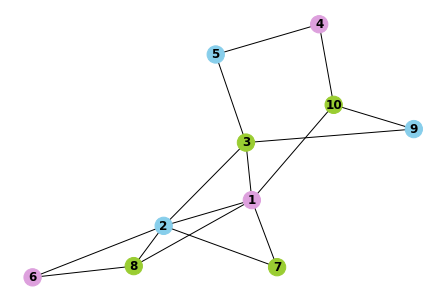

In [190]:
model = Q.compile()
qubo, offset = model.to_qubo()
from pyqubo import solve_qubo

# PyQUBOに備わっているSAを使います
raw_solution = solve_qubo(qubo)
decoded_solution, broken, energy = model.decode_solution(raw_solution, vartype="BINARY")

#結果の表示
print("[Result]")
print()
print(decoded_solution['x'])
print()

#制約を守れているか見ます
print("broken")
print(broken)
print()

cl=["plum","skyblue","yellowgreen"]
colors = []
for i in range(0,N_VER):
    for j in range(1,N_COLOR):
        if decoded_solution['x'][i][j]==1:
            colors.append(cl[j-1])
nx.draw(G, with_labels=True, font_weight='bold',node_color = colors)

## OpenJijに投げる
次にOpenJijのSAで解いてみましょう

In [193]:
# OpenJijのインポートをします
import openjij as oj
# SQAを使います。
sampler = oj.SASampler()
# PYQUBOで使ったquboを使います。
response = sampler.sample_qubo(Q=qubo)
# エネルギーが一番低い状態を取り出します。
dict_solution = response.first.sample
# デコードします。
decoded_solution, broken, energy = model.decode_solution(dict_solution, vartype="BINARY")
# 辞書型をsortして見やすくする処理を追加します。
x_solution = dict(sorted(decoded_solution['x'].items()))
{key:dict(sorted(value.items())) for key, value in x_solution.items()}

{0: {1: 0, 2: 0, 3: 1},
 1: {1: 1, 2: 0, 3: 0},
 2: {1: 0, 2: 1, 3: 0},
 3: {1: 0, 2: 0, 3: 1},
 4: {1: 1, 2: 0, 3: 0},
 5: {1: 0, 2: 0, 3: 1},
 6: {1: 0, 2: 1, 3: 0},
 7: {1: 0, 2: 1, 3: 0},
 8: {1: 1, 2: 0, 3: 0},
 9: {1: 0, 2: 1, 3: 0}}

グラフがどのように色が塗られるか見てみましょう。

broken
{}



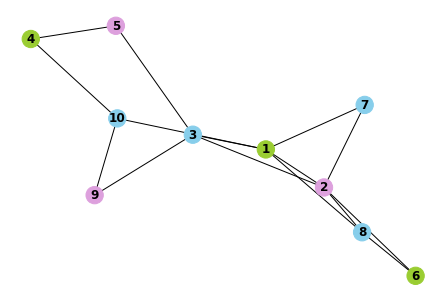

In [194]:
print("broken")
print(broken)
print()
cl=["plum","skyblue","yellowgreen"]
colors = []
for i in range(0,N_VER):
    for j in range(1,N_COLOR):
        if decoded_solution['x'][i][j]==1:
            colors.append(cl[j-1])
nx.draw(G, with_labels=True, font_weight='bold',node_color = colors)

結果を見ると制約を満たしつつ全てのノードを3色で塗り分けられていると分かります。